<a href="https://colab.research.google.com/github/CharmaineLang/obds_charmaine/blob/master/Copy_of_DL_genomics_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial - Deep Learning for Genomics 



In this tutorial we will use a convolutional neuronal network to address a fairly basic but common problem in genomics. Given a set of sequences belonging to different classes, what are the characteristics in the DNA sequence that let us distinguish the classes. For example, given a set of promoter and enhancer sequences, we could ask if there are any patterns in the DNA that let us distinguish between the two.

For a 'simple' example, think of two ChIP-seq experiments for two different transcription factors. After analysing the ChIP-seq data, we know at what positions in the genome the two factors bind and the majority of binding sites might be distinct. If we extract the underlying sequences and search for DNA patterns that are enriched in the respective sets, we get an idea what DNA sequences the transcription factor might bind and/or which co-factors influence their binding.

Traditionally, people use motif discovery tools for finding overrepresented words and motifs. However, if we move to slightly more complicated questions these methods quickly reach their limits and machine learning approaches become more promising.

A more complicated question: If we have multiple sets of enhancers that are active in different tissues and cell types and we have the underlying sequences, can we figure out what sequence patterns are characteristic for what activity? And once we know that can we infer which factors are common and which are tissue specific?

For our test dataset we have a simplfied, simulated version of such a task. We simulated 40,000 DNA sequences of length 200 bp. We split them into 4 enhancer classes and populated them with transcription factor binding motifs and other DNA patters to make them distinguishable. However, some motifs are shared between classes, they may overlap each other and are not necessarily perfect matches to the text book motifs. Thats much more how regulatory DNA actually looks like :)!

We will use keras to build and train a small convolutional neuronal network to classify our enhancer sequences. Once this network is trained well, we can than investigate how the network has learned to distinguish between the classes and try to relate this back to transcriptions factor motifs and so on.

------------

You can run the tutorial in this colab notebook or checkout (and clone) the github repository (https://github.com/rschwess/tutorial_dl_for_genomics). From there you can either run everything in an interactive python or ipython session or (especially later when optimizing) just adjust and run python dl_intro.py in the terminal.

----------------

## Set up 

We will start by downloading the tutorial data. There are more data available on github if you want to work on a slightly more difficult set. 

In [0]:
%%bash

# Download Example Data --------------------------------------------------------

rm -rf ./sample_data/

mkdir -p data

rm -f ./data/*

curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/data/pwm_seq_200bp_test_set.txt >./data/pwm_seq_200bp_test_set.txt
curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/data/pwm_seq_200bp_valid_set.txt >./data/pwm_seq_200bp_valid_set.txt
curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/data/pwm_seq_200bp_train_set.txt >./data/pwm_seq_200bp_train_set.txt


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  198k  100  198k    0     0   832k      0 --:--:-- --:--:-- --:--:--  832k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  198k  100  198k    0     0  1145k      0 --:--:-- --:--:-- --:--:-- 1139k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7533k  100 7533k    0     0  19.6M      0 --:--:-- --:--:-- --:--:-- 19.6M


In [0]:
# # for local
# from google.colab import files
# uploaded = files.upload()

In [0]:
%%bash

# Create some directories and download helper scripts for later ----------------
mkdir -p helper visualize

curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/helper/functions_for_motif_plotting.R >./helper/functions_for_motif_plotting.R
curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/helper/plot_sequence_kernel_weights_per_dir.R >./helper/plot_sequence_kernel_weights_per_dir.R
curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/helper/plot_sequence_kernel_icms_per_dir.R >./helper/plot_sequence_kernel_icms_per_dir.R


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18139  100 18139    0     0   123k      0 --:--:-- --:--:-- --:--:--  123k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1512  100  1512    0     0   6602      0 --:--:-- --:--:-- --:--:--  6573
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1510  100  1510    0     0  11021      0 --:--:-- --:--:-- --:--:-- 11021


Lets start by looking at the data. We have 40,000 sequences and they are all labeled with their respective class. We already split them up into training, test and validation set. It is also a good idea to check if our classes are roughly equally distributed across our different sets.

In [0]:
%%bash 

#%%bash tells it that it is running bash code not python
#Check Data Layout ###########################

# check lines per set
echo "Numbers:"
wc -l ./data/pwm*

# check data format
echo -ne "\nFormat\n"
head -n 3 ./data/pwm_seq_200bp_test_set.txt

# check class representation
echo -ne "\nClass Representations:\n"

echo -ne "\nTraining:\n"
cut -f 1 ./data/pwm_seq_200bp_train_set.txt | sort | uniq -c
echo -ne "\nTest:\n"
cut -f 1 ./data/pwm_seq_200bp_test_set.txt | sort | uniq -c
echo -ne "\nValidation:\n"
cut -f 1 ./data/pwm_seq_200bp_valid_set.txt | sort | uniq -c




Looks good, lets move straight in! We will use keras with tensorflow as its backend. Keras is ideal for quickly writing down and prototyping networks in just a few lines of code. The documentation site will be usefull throught the tutorial https://keras.io/.

We import keras and the relevant layers and operations we need.


In [0]:
# IMPORTING MODULES
%tensorflow_version 1.x

import keras

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D

from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Sequential
import numpy as np
import os
import matplotlib.pyplot as plt

I wrote two helper functions to convert the sequences into hot encoded sequences and a wrapper to read in and assemble the data. Feel free to skip over this but you might want to have a quick look and understand how we format the data. The hot encoding transforms the sequence into an X x 4 array whith rows corresponding to the sequence position and the columns representing the 4 DNA bases. The respective base column that matches the sequence at that position is 1 the rest 0.


In [0]:
# Helper Function  get hotcoded sequence
def get_hot_coded_seq(sequence):
    """Convert a 4 base letter sequence to 4-row x-cols hot coded sequence"""
    # initialise empty
    hotsequence = np.zeros((len(sequence),4))
    # set hot code 1 according to gathered sequence
    for i in range(len(sequence)):
        if sequence[i] == 'A':
            hotsequence[i,0] = 1
        elif sequence[i] == 'C':
            hotsequence[i,1] = 1
        elif sequence[i] == 'G':
            hotsequence[i,2] = 1
        elif sequence[i] == 'T':
            hotsequence[i,3] = 1
    # return the numpy array
    return hotsequence

# Helper function to read in the labels and seqs and store as hot encoded np array
def read_data(infile):
    # read file in
    with open(infile, "r") as f:
        seqs = []
        labels = []
        for i,l in enumerate(f):
            l = l.rstrip()
            l = l.split("\t")
            seqs.append(l[1])
            labels.append(l[0])
    # make labels np.array
    labels = np.array(labels)
    # convert to one_hot_labels
    hot_labels = keras.utils.to_categorical(labels, num_classes=4)
    # make seqs np.array
    hot_seqs = np.zeros( (len(seqs), 200, 4) )
    # fill with hot encoded sequences
    for j in range(len(seqs)):
        hotsequence = get_hot_coded_seq(seqs[j])
        hot_seqs[j,] = hotsequence
    return hot_labels, hot_seqs



Now we can read in the data.


In [0]:
# read data --------------------------------------------------------------------
train_file = "./data/pwm_seq_200bp_train_set.txt"
train_labels, train_seqs = read_data(train_file)
valid_file = "./data/pwm_seq_200bp_valid_set.txt"
valid_labels, valid_seqs = read_data(valid_file)

Lets check how the data looks like after we read it into python and hot encoded it.

In [0]:
# Check Data in Python ---------------------------------------------------------

# check shapes
print("Train Seq Shape", train_seqs.shape)
print("Train Label Shape", train_labels.shape)

# check data format
print("Labels Format:")
print(train_labels[1:5])
print("Seq Format (first 10 bp):")
print(train_seqs[1, 1:10,:])

Train Seq Shape (38000, 200, 4)
Train Label Shape (38000, 4)
Labels Format:
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]
Seq Format (first 10 bp):
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]



The labels have a one hot encoding where every column represents a different class and in this case only one class can be active at a time.

The sequences have shape [sample x sequence_length x base]. We encod the 4 DNA bases as "channels" a term borrowed from image analysis you will encounter a lot when working with tensorlfow. For comparison a set of 2D images would have the dimensions [sample x pixel_rows x pixel_columns x colour_channels]. A grey scale picture would have only one channel while RGB images have three. We can thus think of our sequence as a 1D image with 4 channels.

## Building the Network

We now define our network. We first set some global and network architecture options and put them all together in the keras sequential mode. The sequential mode is an easy wrapper for linearly stacked networks that makes your code even more concise. We just define the model to be sequential and than add/stack layer after layer. Here we use a simple convolutional architecture.

* Our first layer is a 1D convolution over the input:
  * We use a 1D convolution because we only want the filter to move along the sequence axis and map the channels to the hidden units.
  * We start with 10 hidden units or filters or kernels which are all of length 5 (bp)
  * We use the RELU activation function
  * We also define the input shape and how to pad the input if necessary (see doc.)
* We next perform max pooling where we take the maximum of a window of 5 consecutive activation values
  * This reduces the data dimension, thus simplifying the model and speeding up further computations
  * But it also enforces some extend of positional invariance into our model. For example, if we have a match to transcription factor motif in our sequence, we don't necessarily care where exactly this motif lies and a few bp up- or downstream shouldn't make a difference to our predictions.
* We then "Flatten" the activation values to a 1 dimensional vector
* And apply a fully connected or "Dense" layer connecting every value in the 1D vector to every class prediction
  * We use the sigmoid (softmax) activation function to perform effectively a multinomial logistic regression

The number of hidden units, the size of the kernel, the pooling size, but also the number and types of layers we use in the network are usually called hyperparameters. The most work in DL usually comes down to finding the right hyperparameters that let our network training converge and that give us the best possible (at least the best we are able to find) accuracies.

We set some reasonable choices to begin with. But your task will be to play with these hyperparameters and see how well you can tune the model with a few adjustments.

In [0]:
# Define the Model Architecture ------------------------------------------------
# global options
num_classes = 4

# network architecture options
#Can call conv1_hidden_units either filters, kernels or hidden units
#filter_size in this example is how many bases you want it to me
#maxpooll_width just looks at and keeps a max value of 5. Forces position invariance.
#In example below its 10 bases looking at 5 at a time
conv1_hidden_units = 50
conv1_filter_size = 10
maxpool1_width = 3

# construct the model ----------------------------------------------------------
model = Sequential()
#Model.add (.add adds layers to your model)
#activation is the type of activation function. non-linear function in this case everything below 1 is 0 and anything above 0 stays the same
#input_shape this data is 200bp by 4 classes
#padding adds 0's so they are roughly equal
model.add(Conv1D(conv1_hidden_units, kernel_size=(conv1_filter_size), activation='relu', input_shape=(200, 4), padding='same'))
model.add(MaxPooling1D(pool_size=maxpool1_width))
#model.add(Dropout(rate = 0.1))
# # for a second layer add it like this:
model.add(Conv1D(conv1_hidden_units, kernel_size=(conv1_filter_size), activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=maxpool1_width))
model.add(Conv1D(conv1_hidden_units, kernel_size=(conv1_filter_size), activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=maxpool1_width))
#Flatten puts it into a 1D vector
#activation function softmax makes sure the ouput of the function up to 1
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

Next we compile the model. We use adam as our optimizer. Since the classes are mutually exclusive we select the binary_crossentropy as our loss function and we want to monitor the accuracy during training.

We also print a summary of our network telling us the data shapes throught the network and sumarizing the number of trainable parameters in our model.

In [0]:
# compile ----------------------------------------------------------------------
#categorical_crossentropy you use for multiple classes
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model summary ----------------------------------------------------------
#conv1d had 200bp and 4 classes going in and after the first layer we have 200bp by 50 filters = 4050 parameters
model.summary()



Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_43 (Conv1D)           (None, 200, 50)           2050      
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 66, 50)            0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 66, 50)            25050     
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 22, 50)            0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 22, 50)            25050     
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 7, 50)             0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 350)             

## Training

Now that we have our model set up we can train it. We feed the model with our training sequences and labels, we define a batch size (since we are training in batch mode) and set the number of epochs (cycles through the training data) we want to train for. Five epochs should be fine for us feel free to ramp this up a bit and see if you get improvements or if the learning plateus quickly.

In [0]:
# Training Options
#batch size is how many sequences you look at a time
#epochs is the number of times you run it
batch_size = 100
epochs = 10

# Train ------------------------------------------------------------------------
#val_loss tells you the sum of how close to 1 or 0 you are for each of the classes. Just want to see it go down
#want to see the accuracy go up
history = model.fit(train_seqs, train_labels,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(valid_seqs, valid_labels))

Train on 38000 samples, validate on 1000 samples
Epoch 1/10
38000/38000 [==============================] - 2s 53us/sample - loss: 2.4442e-06 - acc: 1.0000 - val_loss: 0.0512 - val_acc: 0.9920
Epoch 2/10
38000/38000 [==============================] - 2s 49us/sample - loss: 1.9909e-06 - acc: 1.0000 - val_loss: 0.0536 - val_acc: 0.9920
Epoch 3/10
38000/38000 [==============================] - 2s 50us/sample - loss: 1.6224e-06 - acc: 1.0000 - val_loss: 0.0548 - val_acc: 0.9920
Epoch 4/10
38000/38000 [==============================] - 2s 51us/sample - loss: 1.2976e-06 - acc: 1.0000 - val_loss: 0.0567 - val_acc: 0.9920
Epoch 5/10
38000/38000 [==============================] - 2s 50us/sample - loss: 1.0981e-06 - acc: 1.0000 - val_loss: 0.0581 - val_acc: 0.9920
Epoch 6/10
38000/38000 [==============================] - 2s 49us/sample - loss: 8.4906e-07 - acc: 1.0000 - val_loss: 0.0580 - val_acc: 0.9920
Epoch 7/10
38000/38000 [==============================] - 2s 49us/sample - loss: 6.9231e-07 -

You will notice that we stored the training output in a **history** variable. We can use this variable to monitor the loss function and accuracy over the training progress.

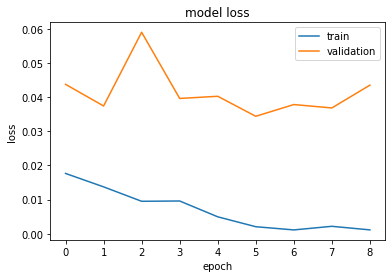

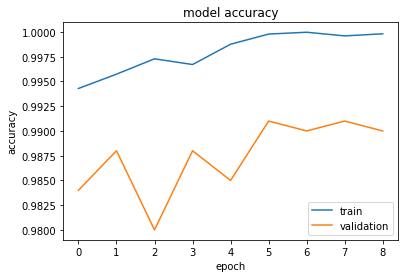

In [0]:
# Plot Training and Validation Loss ------------------------------
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# Plot Training and Validation Accuracy ------------------------------
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Looks alright, the training as well as the validation accuracy is climbing from epoch to epoch and slows down a little more after every epoch. It is now your task to find better hyperparameters for our network and training procedure to see how high up you can get the accuracy. For doing that, I suggest taking dl_intro.py, commenting out all the code after the training, adjust your hyperparameters and/or network architectures how you like and running it in the terminal via python dl_intro.py.

Tipps:

* Should we train longer?
* Do we need more hidden layers?
* Could we max pool over the entire sequence to get one output per filter?
* Would a second layer be beneficial?
* You could also bias the network architechture with some biological knowledge: How long are transcription factor binding motifs in general and what would be an appropriate filter_width then?

(Hint: you can do pretty well in 5 - 10 epochs with minor tweaks!)


Evaluation and Prediction

Once you are happy with you network performance or in case you want to jump ahead first and optimize later, we will evaluate our network on the held out validation data. Technically, we only optimized on the training data set but we always kept an eye on the validation data loss as well. We are discarding all nets that do well on the training but worse at the validation (overfitted), therefore we always have an intrinsic bias. The test data set is meant to have never been touched throughout the whole optimization process and we evaluate the perormance of our final model on this set to get an unbiased estimate of its performance.

In [0]:
# Evaluate ---------------------------------------------------------------------
test_file = "./data/pwm_seq_200bp_test_set.txt"
test_labels, test_seqs = read_data(test_file)
score = model.evaluate(test_seqs, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.04486713627213612
Test accuracy: 0.982




Once we are happy with our network we obviously want to employ it as well. Lets say we have a new sequence we want to classify.


In [0]:
# Predictions ------------------------------------------------------------------
# read test sequences again
with open(test_file, "r") as f:
    seqs = []
    labels = []
    for i,l in enumerate(f):
        l = l.rstrip()
        l = l.split("\t")
        seqs.append(l[1])
        labels.append(l[0])

# select a single sequence
single_seq = seqs[0]
single_label = labels[0]

print("Sequence: " + single_seq)

# hot encode        
hotseq = get_hot_coded_seq(single_seq)

# calculate predictions
single_prediction = model.predict(np.expand_dims(hotseq, axis=0))
print("\nClass Prediction \"Probability\":")
print("\tClass 0 = %s" % single_prediction[0][0])
print("\tClass 1 = %s" % single_prediction[0][1])
print("\tClass 2 = %s" % single_prediction[0][2])
print("\tClass 3 = %s" % single_prediction[0][3])

# print the true class
print("\nTrue Class: " + single_label)


Sequence: ATGGCTGATAATGACGATTGTACAGATGGTGGATGAGATTGCCTCGTCCCGGCAGCATTACCCCCTGGTGGCAACGGCCACCAGGGGGCAATAAATCTGTGTCTTATCTCCGAGACCAAACAATTCCACAGCCTCTTATACAGCACCGAATGGACCGCCCCCTGGTGGCCAGGTATCGTCGAGGGCTCAATTAAACTCCT

Class Prediction "Probability":
	Class 0 = 6.4966355e-10
	Class 1 = 4.1489268e-10
	Class 2 = 0.000101729216
	Class 3 = 0.9998983

True Class: 3


In [0]:
# or just run all predictions for 
all_test_predictions = model.predict(test_seqs)
print(all_test_predictions.shape)
print(all_test_predictions[5:8])

(1000, 4)
[[2.7337469e-11 1.0187924e-06 9.9999869e-01 2.2955918e-07]
 [7.6224779e-08 6.3668665e-07 1.7922590e-05 9.9998140e-01]
 [6.4601805e-03 9.9353987e-01 1.0349394e-13 2.3186862e-13]]



##Inspecting Learned Filters

Now that we have a reasonably working model, we also want to inspect and see what the net has learned. In applications, we often don't care what the network has learned as long as it performs well and outperforms our competitors. For many research problems however, we are exactly interested in what the network has learned. What features distinguish a cat from a dog or if it comes to decision making (e.g. health care or self driving cars), we obviously want to be able to understand and be able to justify why a certain decision has been chosen and learn how to correct missbehavior.

In genomics we usually want to learn what sequence features distinguish the sequences from one another and map them back to biological properties and factors. The easiest way is to just plot the filter weights. In the first convolutional layer, our filters are just like position weight matrices, multiplying every base at every position with a learned weight and summing the value up (plus a bias and pipe it through the RELU activation function). Unfortunatly, this becomes less straight forward to interpret in deeper layers. There are ways of back engineering and learning the importance of filters in higher layers (e.g. https://github.com/kundajelab/deeplift) but we concern ourself only with the simple first layer here.

We can get the weigths of the filters from the model, save them as .txt files and plot them out. I wrote a wrapper to plot the filter weigths for you in R. Run the code, check the filter_X.txt files and look at the plots and try to interpret them. In Colab runs you probaly want to download them.

* Do any look like transciption factor binding sites you know?
* Do you recognize any sequence features that are not binding motifs?
* Can you simplify the sequences/ motifs from the plot an query them in a transcription factor binding motif database (http://jaspar.genereg.net/)
* What is your best bet: Which sequence motifs did we use for simulating the sequence classes?
* Check the input data. Split them up by class into text files with only the sequences one sequence per line (see example). Query them in standard motif analysis tools (e.g. http://rsat.sb-roscoff.fr/oligo-analysis_form.cgi or http://meme-suite.org/tools/meme). Do these tools find different or similar things?


In [0]:
# Inspect weights --------------------------------------------------------------
model_weights = model.get_weights()
filter_weights = model_weights[0]

# save conv filter weights
for k in range(model_weights[0].shape[2]):
    # save single filter weights
    np.savetxt(("./visualize/filter_%s.txt" % k), filter_weights[:,:,k], delimiter="\t")

In [0]:
%%bash

# Plot them using the supplied R script
Rscript ./helper/plot_sequence_kernel_weights_per_dir.R ./visualize ./visualize plot_weight 5 2.5

 [1] "filter_0.txt"  "filter_1.txt"  "filter_10.txt" "filter_11.txt"
 [5] "filter_12.txt" "filter_13.txt" "filter_14.txt" "filter_15.txt"
 [9] "filter_16.txt" "filter_17.txt" "filter_18.txt" "filter_19.txt"
[13] "filter_2.txt"  "filter_20.txt" "filter_21.txt" "filter_22.txt"
[17] "filter_23.txt" "filter_24.txt" "filter_25.txt" "filter_26.txt"
[21] "filter_27.txt" "filter_28.txt" "filter_29.txt" "filter_3.txt" 
[25] "filter_30.txt" "filter_31.txt" "filter_32.txt" "filter_33.txt"
[29] "filter_34.txt" "filter_35.txt" "filter_36.txt" "filter_37.txt"
[33] "filter_38.txt" "filter_39.txt" "filter_4.txt"  "filter_40.txt"
[37] "filter_41.txt" "filter_42.txt" "filter_43.txt" "filter_44.txt"
[41] "filter_45.txt" "filter_46.txt" "filter_47.txt" "filter_48.txt"
[45] "filter_49.txt" "filter_5.txt"  "filter_6.txt"  "filter_7.txt" 
[49] "filter_8.txt"  "filter_9.txt" 
[1] "Saving Plot filter_0.png"
[1] "Saving Plot filter_1.png"
[1] "Saving Plot filter_10.png"
[1] "Saving Plot filter_11.png"
[1] "Savi

Now thay don't look the nice motifs with information content we are used to look at from ChIP-seq analysis and such. Our filters have positive and negative values all contributing to the "matching score" of a filter at a given position. In contrast, information content motifs don't have negative values just less informative bases that occur less often in a, let's say, binding site. Luckily there is a [transformation](https://www.biorxiv.org/content/10.1101/163220v2) we can apply to the filter weights to derive information content. For our purposes her just use the helper script that implements the transformation.

In [0]:
%%bash

# Plot ICM like motifs using the supplied R script
Rscript ./helper/plot_sequence_kernel_icms_per_dir.R ./visualize ./visualize plot_motif 5 2.5

 [1] "filter_0.txt"  "filter_1.txt"  "filter_10.txt" "filter_11.txt"
 [5] "filter_12.txt" "filter_13.txt" "filter_14.txt" "filter_15.txt"
 [9] "filter_16.txt" "filter_17.txt" "filter_18.txt" "filter_19.txt"
[13] "filter_2.txt"  "filter_20.txt" "filter_21.txt" "filter_22.txt"
[17] "filter_23.txt" "filter_24.txt" "filter_25.txt" "filter_26.txt"
[21] "filter_27.txt" "filter_28.txt" "filter_29.txt" "filter_3.txt" 
[25] "filter_30.txt" "filter_31.txt" "filter_32.txt" "filter_33.txt"
[29] "filter_34.txt" "filter_35.txt" "filter_36.txt" "filter_37.txt"
[33] "filter_38.txt" "filter_39.txt" "filter_4.txt"  "filter_40.txt"
[37] "filter_41.txt" "filter_42.txt" "filter_43.txt" "filter_44.txt"
[41] "filter_45.txt" "filter_46.txt" "filter_47.txt" "filter_48.txt"
[45] "filter_49.txt" "filter_5.txt"  "filter_6.txt"  "filter_7.txt" 
[49] "filter_8.txt"  "filter_9.txt" 
[1] "Saving Plot filter_0.png"
[1] "Saving Plot filter_1.png"
[1] "Saving Plot filter_10.png"
[1] "Saving Plot filter_11.png"
[1] "Savi

A little wrapper to zip all plots and filter weigths into a tar.gz. Gownload them from the files menu.

In [0]:
%%bash

tar czvf visualize.tar.gz ./visualize 

./visualize/
./visualize/filter_0.txt
./visualize/filter_48.txt
./visualize/plot_weight_filter_4.png
./visualize/plot_motif_filter_0.png
./visualize/plot_motif_filter_44.png
./visualize/filter_45.txt
./visualize/filter_6.txt
./visualize/filter_47.txt
./visualize/filter_12.txt
./visualize/plot_motif_filter_30.png
./visualize/filter_13.txt
./visualize/plot_weight_filter_17.png
./visualize/plot_weight_filter_47.png
./visualize/plot_motif_filter_3.png
./visualize/plot_weight_filter_37.png
./visualize/plot_motif_filter_46.png
./visualize/plot_motif_filter_25.png
./visualize/plot_motif_filter_17.png
./visualize/plot_motif_filter_9.png
./visualize/plot_weight_filter_11.png
./visualize/plot_motif_filter_12.png
./visualize/plot_motif_filter_32.png
./visualize/filter_19.txt
./visualize/filter_22.txt
./visualize/filter_30.txt
./visualize/filter_10.txt
./visualize/filter_31.txt
./visualize/plot_motif_filter_29.png
./visualize/plot_weight_filter_24.png
./visualize/plot_motif_filter_42.png
./visuali

## Visualize Importance

A popular approach to visualize and start to interpret the importance of sequence features is the so called **Saliency**. This term has been introduced to descripe the gradient of the model output with respect to a sequence input. In other words, how much would the prediction change if we were to change a single base pair. Here change mean changing the *1* in the hot encoding to a marginally different value e.g. *1.00001*. 


I nicked this function and visualization was adapted from the James Zhou's [Primer on Genomics](https://colab.research.google.com/drive/17E4h5aAOioh5DiTo7MZg4hpL6Z_0FyWr#scrollTo=WNT_Au-dAP8a) colab notebook. Check it out and the paper is worth a read.


In summary, what we are doing here is calculating the gradient of the model ouput with respect to a single sequence input. We then multiply this gradient with the one hot endoded sequence, effectively zeroing all non present bases, and then sum this over the 4 output classes and trim everything below zero (for pure ease of visualization).

In [0]:
import tensorflow.keras.backend as K

def compute_salient_bases(model, x):
  
  input_tensors = [model.input]
  gradients = model.optimizer.get_gradients(model.output, model.input)
  compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
  
  gradients = compute_gradients([x])[0][0]
  x = np.squeeze(x, axis = 0)  
  sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)

  return sal

In [0]:
# use a single sequence again (index 1 works well)
selected_index = 15

single_seq = seqs[selected_index]

# hot encode        
hotseq = get_hot_coded_seq(single_seq)

hotseq = np.expand_dims(hotseq, axis=0)

# calculate predictions
single_prediction = model.predict(hotseq)

print("Prediction: %s" % single_prediction)

print("True Label: %s" % labels[selected_index])

Prediction: [[4.1074711e-07 1.1690945e-06 9.9762874e-05 9.9989867e-01]]
True Label: 3


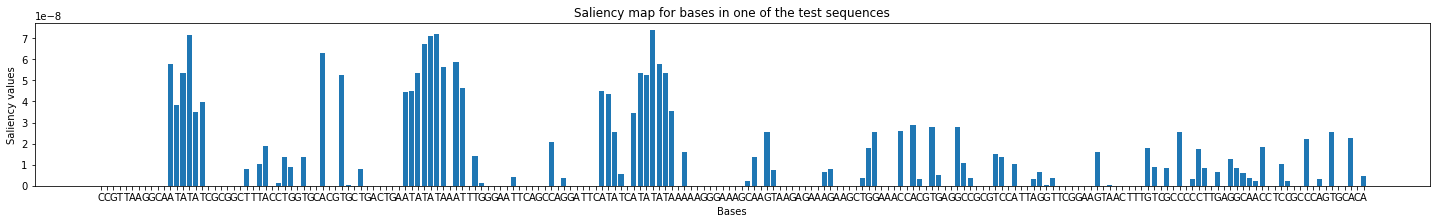

In [0]:
sal = compute_salient_bases(model, hotseq)


plt.figure(figsize=[25,3])
barlist = plt.bar(np.arange(len(sal)), sal)
plt.xlabel('Bases')
plt.ylabel('Saliency values')
plt.xticks(np.arange(len(sal)), list(single_seq));
plt.title('Saliency map for bases in one of the test sequences');

## Further

On the github page you wild find links to a slightly more difficult set, using more motifs and 300 bp sequences.
You can adapt the notebook to run on those.
